# **Fake News Prediction**

In [ ]:
pip install opendatasets --upgrade

In [ ]:
# Import Libraries

import pandas as pd
import numpy as np

from scipy.stats import randint
from scipy.stats import uniform

import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn import model_selection
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, cross_val_predict, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

colors = ['firebrick', 'tomato']

import warnings
warnings.filterwarnings('ignore')

##### Loading Data

In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/competitions/fake-news/data")

In [ ]:
import os
dir = "./fake-news"
os.listdir(dir)

train_dir = dir + "/train.csv"
test_dir = dir + "/test.csv"

In [ ]:
train = pd.read_csv(train_dir)
test = pd.read_csv(test_dir)

### **Understanding the data**

In [ ]:
# Check the shape of the train and test sets

print("Size of train set: ", train.shape)
print("Size of test set: ", test.shape)

Size of train set:  (20800, 5)
Size of test set:  (5200, 4)


In [ ]:
# Print the first 5 rows

train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
# Data description

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
dtypes: int64(1), object(3)
memory usage: 162.6+ KB


In [ ]:
# Target variable distribution

train.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

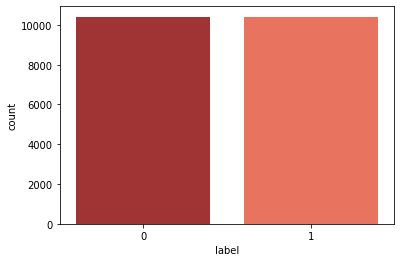

In [ ]:
# Visualizing the target distribution

sns.countplot(train['label'], palette=colors);

The target variable is fairly balanced

### **Data Cleaning**

In [ ]:
# Checking null instances

train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [ ]:
# Replacing the null values with empty string

train = train.fillna('')

In [ ]:
train.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [ ]:
test = test.fillna('')

In [ ]:
test.isnull().sum()

id        0
title     0
author    0
text      0
dtype: int64

In [ ]:
# Checking duplicate data

train.duplicated('title').sum(), test.duplicated('title').sum()

(996, 143)

In [ ]:
# Dropping duplicates

train.drop_duplicates(subset="title",keep='first', ignore_index=True, inplace=True)
test.drop_duplicates(subset="title",keep='first', ignore_index=True, inplace=True)

In [ ]:
# Print shape 

print("Size of train set: ", train.shape)
print("Size of test set: ", test.shape)

Size of train set:  (19804, 5)
Size of test set:  (5057, 4)


In [ ]:
# Unique values of authors 

train.author.value_counts()

                                             1896
Pam Key                                       243
admin                                         180
Jerome Hudson                                 166
Charlie Spiering                              141
                                             ... 
Bill Federer                                    1
Ben Sisario and Joe Coscarelli                  1
David L. Kirp                                   1
James Andrew Miller                             1
Michael J. de la Merced and Rachel Abrams       1
Name: author, Length: 3826, dtype: int64

In [ ]:
train.author.nunique()

3826

In [ ]:
test.author.value_counts()

                                                            496
Pam Key                                                      65
admin                                                        53
Jerome Hudson                                                53
Charlie Spiering                                             38
                                                           ... 
Ted Loos                                                      1
Julie Hirschfeld Davis, Michael D. Shear and Peter Baker      1
Maria Afonina                                                 1
Brian McNicoll                                                1
Teddy Wayne                                                   1
Name: author, Length: 1641, dtype: int64

In [ ]:
test.author.nunique()

1641

There are similar authors with multiple articles in the train set and test set. This variable is relevant for prediction

### **Data Preprocessing**

In [ ]:
# Merging the author and title columns

train['text'] = train['author'] + ' ' + train['text']

In [ ]:
print(train['text'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn Ever get the feeling your life...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss Videos 15 Civilians Killed In ...
4        Howard Portnoy Print \nAn Iranian woman has be...
                               ...                        
19799    Lee Stranahan Donald Trump took to Twitter Fri...
19800    Jerome Hudson Rapper T. I. unloaded on black c...
19801    Benjamin Hoffman When the Green Bay Packers lo...
19802    Michael J. de la Merced and Rachel Abrams The ...
19803    Alex Ansary NATO, Russia To Hold Parallel Exer...
Name: text, Length: 19804, dtype: object


In [ ]:
# Merging the author and test columns on the test set

test['text'] = test['author'] + ' ' + test['text']

In [ ]:
test['text'].head()

0    David Streitfeld PALO ALTO, Calif.  —   After ...
1     Russian warships ready to strike terrorists n...
2    Common Dreams Videos #NoDAPL: Native American ...
3    Daniel Victor If at first you don’t succeed, t...
4    Truth Broadcast Network 42 mins ago 1 Views 0 ...
Name: text, dtype: object

##### Lemmatization

In [ ]:
# This function removes numbers, punctuation marks, converts the text to lowercase and reduces words to their root words

lemmatizer = WordNetLemmatizer() # Links words into semantic relations
stop_words = list(stopwords.words('english'))

# Train data

for x in range(len(train)) :
    corpus = []
    review = train['text'][x]
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stop_words :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    train['text'][x] = review      

In [ ]:
train['text'].head()

0    darrell lucus house dem aide didnt even see co...
1    daniel j flynn ever get feeling life circle ro...
2    consortiumnewscom truth might get fired octobe...
3    jessica purkiss video civilian killed single u...
4    howard portnoy print iranian woman sentenced s...
Name: text, dtype: object

In [ ]:
# Lemmatization of the test data 

for p in range(len(test)) :
    corpus = []
    review = test['text'][p]
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stop_words :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    test['text'][p] = review  

P = test['text'] 

##### Vectorization

In [ ]:
# Defining the predictor and response variables

X = train['text'].values
Y = train['label'].values

In [ ]:
# Converting text into numbers

vectorizer = TfidfVectorizer()
vectorizer.fit(X)

# Train data

X = vectorizer.transform(X)

print(X)

  (0, 162755)	0.050436438406085735
  (0, 162635)	0.009861617799785208
  (0, 161420)	0.045601845019642304
  (0, 161408)	0.07332573083938157
  (0, 161276)	0.038849045670666896
  (0, 161203)	0.013545016522383312
  (0, 160469)	0.06177153005343979
  (0, 159373)	0.02162202849406224
  (0, 159160)	0.017476717419419877
  (0, 158926)	0.012697285153678432
  (0, 158812)	0.03469258113345222
  (0, 158692)	0.06177153005343979
  (0, 158399)	0.012056689289357695
  (0, 157202)	0.029276734044355907
  (0, 157171)	0.0224107029835225
  (0, 157106)	0.0174969098698063
  (0, 155791)	0.02220039859707576
  (0, 154024)	0.0673512572727459
  (0, 152871)	0.03570735890881373
  (0, 152534)	0.01780603703413158
  (0, 151369)	0.041701779861394644
  (0, 150537)	0.011399330875989629
  (0, 150511)	0.0449996206389361
  (0, 150408)	0.05830142943357925
  (0, 150406)	0.07713766157212253
  :	:
  (19803, 35151)	0.03367295518601229
  (19803, 34161)	0.01895484894095927
  (19803, 30997)	0.0489383990770253
  (19803, 30961)	0.06147047

In [ ]:
# Test data is only transformed

P = vectorizer.transform(P) 

print(P)

  (0, 163106)	0.013134884863498859
  (0, 162867)	0.013574906990888378
  (0, 162635)	0.008385412743798594
  (0, 161665)	0.014768852643262253
  (0, 161447)	0.032804362449606
  (0, 161371)	0.02199892635100618
  (0, 161351)	0.023891660009469646
  (0, 161276)	0.011011218418216638
  (0, 161250)	0.028760561287399122
  (0, 161218)	0.01803080472485452
  (0, 161203)	0.011517436232849076
  (0, 160039)	0.018091440790563386
  (0, 160009)	0.033794099796153186
  (0, 159841)	0.015304272321770793
  (0, 159458)	0.01937955540710635
  (0, 159160)	0.044581779159529655
  (0, 158926)	0.03238981034378117
  (0, 158680)	0.022338931031091868
  (0, 158630)	0.017837764235410048
  (0, 158399)	0.010251899644417577
  (0, 158138)	0.027022408999562233
  (0, 157864)	0.03267929213250047
  (0, 157861)	0.011222468319699063
  (0, 157706)	0.016848268907827178
  (0, 157679)	0.020881548144559937
  :	:
  (5056, 6693)	0.04847160115449645
  (5056, 6440)	0.022676721403006358
  (5056, 6191)	0.022959956730511773
  (5056, 6060)	0.045

### **Data Modeling**

In [ ]:
# Split the train to get a validation set

x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.3, stratify=Y)

##### Finding base models 

In [ ]:
# Putting models into a dictionary

models = {"Logistic Regression" : LogisticRegression(),
          "Random Forest" : RandomForestClassifier(),
          "Linear SVC" : LinearSVC(),
          "XGBoost Classifier": XGBClassifier(),
          "Ridge Classifier" : RidgeClassifier (),
          "SGD Classifier" : SGDClassifier(),
          }
          
# Function that will fit and score models

def fit_and_score(models, x_train,x_valid,y_train,y_valid):
    """
    fits and evaluates given machine learning models
    models : a dictionary of different ML models
    x_train : training data (no labels)
    x_valid : validation data (no labels)
    y_train : training labels
    y_valid : validation labels
    """
    # Setting up a random seed

    random_state=42
 
    # Making a dictionary to keep model scores

    model_scores = {}

    # Looping through models
    
    for name, model in models.items():
        # Fitting the models to the data
        model.fit(x_train, y_train)
        # Evaluating the model and appending its score to model_scores
        model_scores[name] = model.score(x_valid, y_valid)
    return model_scores

In [ ]:
%%time
scores = fit_and_score(models = models,
                      x_train = x_train,
                      x_valid = x_valid,
                      y_train = y_train,
                      y_valid = y_valid)
scores

CPU times: user 5min 2s, sys: 10.2 s, total: 5min 12s
Wall time: 3min 21s


{'Logistic Regression': 0.9454729047458769,
 'Random Forest': 0.9101312689330192,
 'Linear SVC': 0.9612924941097274,
 'XGBoost Classifier': 0.9548973409626389,
 'Ridge Classifier': 0.9643217771794009,
 'SGD Classifier': 0.9584315045439246}

##### Comparing the models

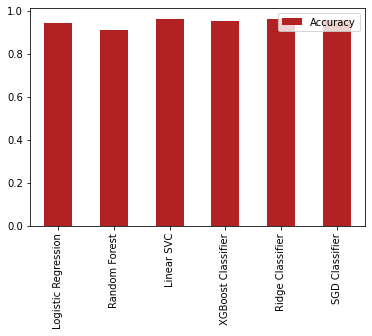

In [ ]:
# Visual comparison of the models

model_compare = pd.DataFrame(scores, index=['Accuracy'])
model_compare.T.plot.bar(color= 'firebrick');# Transpose to improve the plot

Ridge Classifier has the highest accuracy score

**Hyperparameter Tuning Using Random Search**

In [ ]:
# RidgeClassifier hyperparameter tuning using randomized search
ridge_param_dist = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'max_iter': randint(1000, 5000)
}

ridge_rs = RandomizedSearchCV(RidgeClassifier(), param_distributions=ridge_param_dist, cv=5, n_iter=20, random_state=42)
ridge_rs.fit(x_train, y_train)

# Evaluate models on validation set
ridge_acc = accuracy_score(y_valid, ridge_rs.predict(x_valid))

print('Ridge Classifier validation accuracy: {:.5f}'.format(ridge_acc))

Ridge Classifier validation accuracy: 0.96432


**Evaluating our model**

In [ ]:
# Setting up sratified k-fold cross validation

kfold = StratifiedKFold(n_splits= 5)

# Predictions

y_pred = ridge_rs.predict(x_valid)
score= accuracy_score(y_valid, y_pred)
print(f'Accuracy: {round(score*100,2)}%')

# Evaluating our algorithm

print(confusion_matrix(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

results = model_selection.cross_val_score(ridge_rs, X, Y, cv=kfold) 
print(f'Results: {round(results.mean()*100,2)}%')

Accuracy: 96.43%
[[2979  136]
 [  76 2751]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3115
           1       0.95      0.97      0.96      2827

    accuracy                           0.96      5942
   macro avg       0.96      0.96      0.96      5942
weighted avg       0.96      0.96      0.96      5942

Results: 96.52%


The cross validation score is higher than the accuracy score.

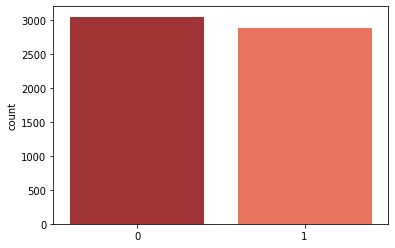

In [ ]:
sns.countplot(y_pred, palette=colors);

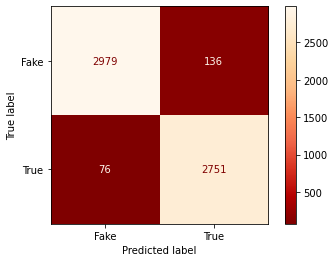

In [ ]:
# Visualizing the confusion matrix for the true and predicted values

matrix = confusion_matrix(y_valid,y_pred)
display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels=["Fake","True"])
display.plot(cmap='OrRd_r')
plt.show()

**Predictions on test set**

In [ ]:
# Make prediction on the test set

predictions = ridge_rs.predict(P)
predictions

array([0, 1, 1, ..., 0, 1, 0])

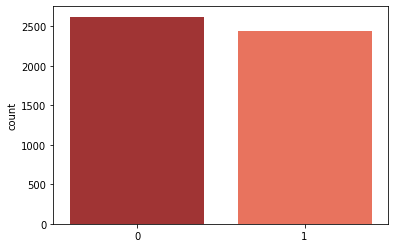

In [ ]:
# Create a submission file
sub = pd.read_csv('/content/fake-news/submit.csv')
sub_file = sub.copy()
sub_file.predictions = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.predictions, palette=colors);

In [ ]:
# Create a csv file

sub_file.to_csv('FakeNewsPred.csv', index = False)